In [1]:
import torch
from torch import nn


In [2]:
m = nn.AdaptiveAvgPool2d((5,7))
input = torch.randn(1, 64, 8, 9)
output = m(input)
print(output.shape)
# >>> # target output size of 7x7 (square)
# >>> m = nn.AdaptiveAvgPool2d(7)
# >>> input = torch.randn(1, 64, 10, 9)
# >>> output = m(input)
# >>> # target output size of 10x7
# >>> m = nn.AdaptiveAvgPool2d((None, 7))
# >>> input = torch.randn(1, 64, 10, 9)
# >>> output = m(input)

torch.Size([1, 64, 5, 7])


In [3]:
m = nn.AdaptiveAvgPool2d((1,1))
input = torch.randn(1, 64, 8, 9)
output = m(input)
print(output.shape)

torch.Size([1, 64, 1, 1])


## Dataset

In [4]:
from typing import Tuple
import numpy as np
import torch
from torchvision.transforms import ToTensor
from torch.utils import data
from skimage.transform import resize
from skimage import io, color
from scipy import io as spio
import pickle
import cv2
import albumentations as A
from utils.data_process import pad_image, match_histograms, normalize_min_max, normalize_mean_std

In [5]:
from matplotlib import pyplot as plt


In [9]:
class Dataset(data.Dataset):
    def __init__(self, image_sequences, image_keypoints,
                 im_size=(1, 256, 256),
                 train=True, shuffle=False, register_limit=5,
                 use_masks=True, use_crop=False):
        """
        
        :param: image_sequences:
        :param: image_keypoints:
        :param: im_size:
        :param: train:
        :param: register_limit:
        :param: shuffle:
        :param: use_masks:
        :param: use_crop:
        """
        self.image_sequences = []
        self.image_keypoints = []
        self.image_masks = []
        self.use_masks = use_masks
        
        for sequence_path, keypoint_path in zip(image_sequences, image_keypoints):
            assert sequence_path.split('/')[-1].split('.')[0] == \
            keypoint_path.split('/')[-1].split('.')[0], 'Keypoint and sequence files must be ordered!'
            
            seq = io.imread(sequence_path)
            if seq.shape[-1] == 3:
                seq = color.rgb2gray(seq)
            self.image_sequences.append(seq)
            
            if self.use_masks:
                mask_seq = io.imread(sequence_path.replace('.tif', '_mask.tif'))
                if mask_seq.shape[-1] == 3:
                    mask_seq = mask_seq.sum(-1)
                mask_seq = 1. - np.clip(np.array(mask_seq, dtype=np.float32), 0., 1.)
                self.image_masks.append(mask_seq)
            
            poi = spio.loadmat(keypoint_path)
            bound = np.stack(poi['spotsB'][0].squeeze())
            inner = np.stack(poi['spotsI'][0].squeeze())

            bound = bound[:, :, :2]
            inner = inner[:, :, :2]

            line1 = np.stack(poi['lines'][:, 0])
            line2 = np.stack(poi['lines'][:, 1])
            line3 = np.stack(poi['lines'][:, 2])
            line4 = np.stack(poi['lines'][:, 3])

            len1 = len(line1[0])
            len2 = len(line2[0])
            len3 = len(line3[0])
            len4 = len(line4[0])

            lines = np.concatenate((line1, line2, line3, line4), axis=1)
            lines_lengths = np.array([len1, len2, len3, len4])
            self.image_keypoints.append({'inner': inner, 'bound': bound, 'lines': (lines, lines_lengths)})
            

        self.seq_numeration = []
        

        for seq_idx, _ in enumerate(self.image_sequences):
            for i, _ in enumerate(self.image_sequences[seq_idx]):
                self.seq_numeration.append((seq_idx, i))
                
        self.length = len(self.seq_numeration)
        print('Dataset length is ', self.length)

        self.use_crop = use_crop
        
        self.im_size = im_size[1:]
        self.train = train
        self.shuffle = shuffle
        
        if isinstance(register_limit, int):
            self.register_limit = [register_limit] * len(self.image_sequences)
        else:
            assert len(register_limit) == len(self.image_sequences), 'limit value must be assigned either \
            by integer or by the list of values for each mage sequence accordingly'
            
            self.register_limit = register_limit
        
        
        if self.shuffle:
            np.random.shuffle(self.seq_numeration)
#         TODO add aug
        if self.train:
            self.aug_pipe = A.Compose([A.OneOf([A.RandomBrightnessContrast(brightness_limit=0.01, contrast_limit=0.01),
#                                                 A.RandomResizedCrop(self.im_size[-2], self.im_size[-1]),
                                                A.ShiftScaleRotate(shift_limit=0.0225, scale_limit=0.1, 
                                                                    rotate_limit=30)], p=0.2)],
                                      additional_targets={'image2': 'image', 'keypoints2': 'keypoints',
                                                         'mask2': 'mask'},
                                       keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))
        
        self.to_tensor = ToTensor()
        self.resize = A.Compose([A.Resize(*self.im_size)],
                                keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))
        
    def __len__(self):
        return self.length

    def __getitem__(self, index):
        seq_idx, it = self.seq_numeration[index]
        current_seq_len = len(self.image_sequences[seq_idx])
        
        if self.train:
            it2 = np.random.randint(max(it-self.register_limit[seq_idx], 0),
                                    min(it+self.register_limit[seq_idx] + 1, current_seq_len - 1))
        else:
            it2 = min(it + 1, current_seq_len - 1)

        image1 = self.image_sequences[seq_idx][it].squeeze().astype(np.float32)
        image2 = self.image_sequences[seq_idx][it2].squeeze().astype(np.float32)
        
        image1 = normalize_mean_std(image1)
        image2 = normalize_mean_std(image2)
        
        image1, image2, swap_flag = match_histograms(image1, image2, random_switch=self.train)
        if swap_flag:
            tmp = it
            it = it2
            it2 = tmp
        
        if self.use_masks:
            mask1 = self.image_masks[seq_idx][it].squeeze()
            mask2 = self.image_masks[seq_idx][it2].squeeze()
        
            
        inner1 = np.array(self.image_keypoints[seq_idx]['inner'][it]).reshape(-1, 2)
        inner2 = np.array(self.image_keypoints[seq_idx]['inner'][it2]).reshape(-1, 2)
        bound1 = np.array(self.image_keypoints[seq_idx]['bound'][it]).reshape(-1, 2)
        bound2 = np.array(self.image_keypoints[seq_idx]['bound'][it2]).reshape(-1, 2)
        lines1 = np.array(self.image_keypoints[seq_idx]['lines'][0][it]).reshape(-1, 2)
        lines_len = self.image_keypoints[seq_idx]['lines'][1]
        lines2 = np.array(self.image_keypoints[seq_idx]['lines'][0][it2]).reshape(-1, 2)
        h, w = image1.shape
        
        if self.use_crop:
            x0 = np.random.randint(0, w - self.im_size[1])
            y0 = np.random.randint(0, h - self.im_size[0])
            image1 = image1[y0: y0 + self.im_size[0], x0:x0 + self.im_size[1]]
            image2 = image2[y0: y0 + self.im_size[0], x0:x0 + self.im_size[1]]
            if self.use_masks:
                mask1 = mask1[y0: y0 + self.im_size[0], x0:x0 + self.im_size[1]]
                mask2 = mask2[y0: y0 + self.im_size[0], x0:x0 + self.im_size[1]]
            inner1 -= np.array([x0, y0]).reshape(1, 2)
            inner2 -= np.array([x0, y0]).reshape(1, 2)
            bound1 -= np.array([x0, y0]).reshape(1, 2)
            bound2 -= np.array([x0, y0]).reshape(1, 2)
            lines1 -= np.array([x0, y0]).reshape(1, 2)
            lines2 -= np.array([x0, y0]).reshape(1, 2)
        else:
            h, w = image1.shape
            
            if h != w:
                if h < w:
                    image1 = pad_image(image1, (0, w - h, 0, 0))
                    image2 = pad_image(image2, (0, w - h, 0, 0))
                    if self.use_masks:
                        mask1 = pad_image(mask1, (0, w - h, 0, 0))
                        mask2 = pad_image(mask2, (0, w - h, 0, 0))
                else:
                    image1 = pad_image(image1, (0, 0, 0, h - w))
                    image2 = pad_image(image2, (0, 0, 0, h - w))
                    if self.use_masks:
                        mask1 = pad_image(mask1, (0, 0, 0, h - w))
                        mask2 = pad_image(mask2, (0, 0, 0, h - w))
                    
        inner_len1 = len(inner1)
        bound_len1 = len(bound1)
        points_len = np.array([inner_len1, bound_len1, *lines_len])
        points1 = np.concatenate([inner1, bound1, lines1], axis=0).astype(np.float32)
        if self.use_masks:
            data1 = self.resize(image=image1, mask=mask1, keypoints=points1)
            image1, points1, mask1 =  data1['image'], np.array(data1['keypoints'], 
                                                               dtype=np.float32), data1['mask']
        else:
            data1 = self.resize(image=image1, keypoints=points1)
            image1, points1 =  data1['image'], np.array(data1['keypoints'], dtype=np.float32)

        inner_len2 = len(inner2)
        bound_len2 = len(bound2)
        assert inner_len2 == inner_len1
        assert bound_len2 == bound_len1

        points2 = np.concatenate([inner2, bound2, lines2], axis=0).astype(np.float32)
        if self.use_masks:
            data2 = self.resize(image=image2, mask=mask2, keypoints=points2)
            image2, points2, mask2 =  data2['image'], np.array(data2['keypoints'], 
                                                               dtype=np.float32), data2['mask']
        else:
            data2 = self.resize(image=image2, keypoints=points2)
            image2, points2 =  data2['image'], np.array(data2['keypoints'], dtype=np.float32)
        points1 = np.clip(points1, 0., self.im_size[1]-1)
        points2 = np.clip(points2, 0., self.im_size[1]-1)

        if self.train:
            h, w = self.im_size[-2:]
            if np.random.rand() < 0.5:
                image1 = image1[:, ::-1].copy()
                image2 = image2[:, ::-1].copy()
                if self.use_masks:
                    mask1 = mask1[:, ::-1].copy()
                    mask2 = mask2[:, ::-1].copy()
                points1[:, 0] = w - 1 - points1[:, 0]
                points2[:, 0] = w - 1 - points2[:, 0]


            if np.random.rand() < 0.5:
                image1 = image1[::-1].copy()
                image2 = image2[::-1].copy()
                if self.use_masks:
                    mask1 = mask1[::-1].copy()
                    mask2 = mask2[::-1].copy()
                points1[:, 1] = h - 1 - points1[:, 1]
                points2[:, 1] = h - 1 - points2[:, 1]
            if self.use_masks:
                data = self.aug_pipe(image=image1, mask=mask1, keypoints=points1,
                                    image2=image2, mask2=mask2, keypoints2=points2,)
                image1, points1, mask1 =  data['image'], np.array(data['keypoints']), data['mask']
                image2, points2, mask2 =  data['image2'], np.array(data['keypoints2']), data['mask2']
            else:
                data = self.aug_pipe(image=image1, keypoints=points1,
                                    image2=image2, keypoints2=points2,)
                image1, points1 =  data['image'], np.array(data['keypoints'])
                image2, points2 =  data['image2'], np.array(data['keypoints2'])
                
        image1 = self.to_tensor(image1).float()
        image2 = self.to_tensor(image2).float()

        if self.use_masks:
            image1 = torch.cat([image1, torch.Tensor(mask1).float()[None]], 0)
            image2 = torch.cat([image2, torch.Tensor(mask2).float()[None]], 0)
        
        # points1[:, 0] /= self.im_size[1]
        # points1[:, 1] /= self.im_size[0]
        # points2[:, 0] /= self.im_size[1]
        # points2[:, 1] /= self.im_size[0]
        
        return image1, image2, points1, points2, points_len


Dataset length is  42
(876, 2) (876, 2)


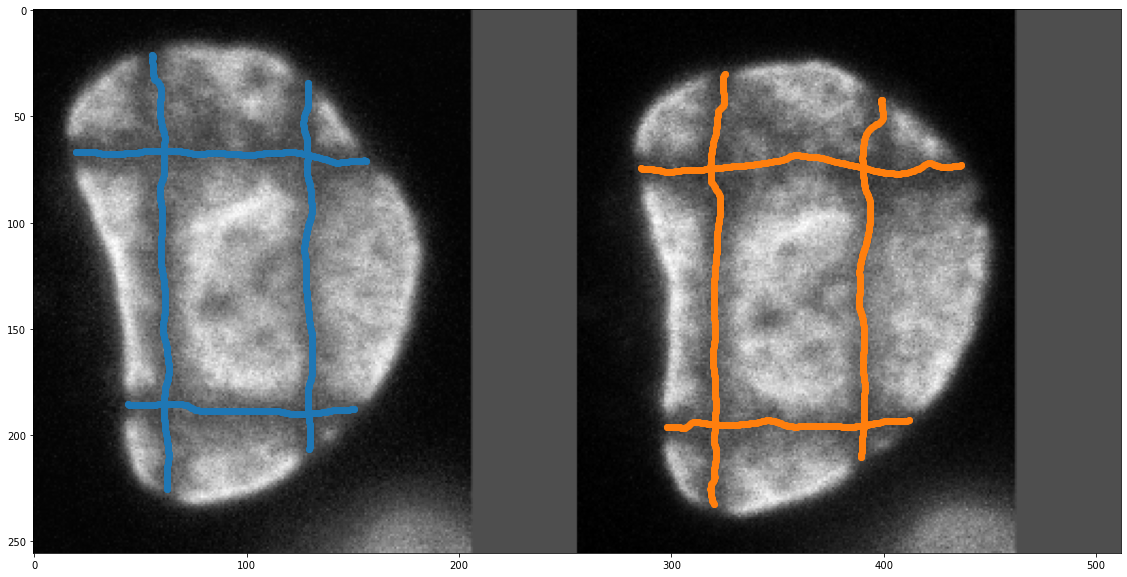

In [10]:
dataset = Dataset(['../../Data/DefCells/SeqB/SeqB1.tif'], ['../../Data/DefCells/SeqB/SeqB1.mat'], train=True,
                 use_crop=False, use_masks=False)

image1, image2, points1, points2, total_len = dataset[0]

print(points1.shape, points2.shape)

image1 = image1.numpy().squeeze()
image2 = image2.numpy().squeeze()
points2[:, 0] += dataset.im_size[0]

if dataset.use_masks:
    image1, mask1 = image1[0], image1[1]
    image2, mask2 = image2[0], image2[1]
    plt.figure(figsize=(20, 10))
    plt.imshow(np.concatenate([mask1, mask2], 1), cmap='gray')
    plt.scatter(points1[:, 0], points1[:, 1])
    plt.scatter(points2[:, 0], points2[:, 1])

plt.figure(figsize=(20, 10))
plt.imshow(np.concatenate([image1, image2], 1), cmap='gray')
plt.scatter(points1[:, 0], points1[:, 1])
plt.scatter(points2[:, 0], points2[:, 1])

# for i in range(42):
#     print(i)
#     image1, image2, points1, points2, total_len = dataset[i]


In [11]:
from torch.utils.data import DataLoader


loader = DataLoader(dataset, batch_size=3)

for batch in loader:
    print(len(batch))
    for item in batch:
        print(item.shape)
    break

5
torch.Size([3, 1, 256, 256])
torch.Size([3, 1, 256, 256])
torch.Size([3, 876, 2])
torch.Size([3, 876, 2])
torch.Size([3, 6])


In [17]:
from collections import defaultdict
from utils.points_error_calculation import frechetDist

batch_fixed, batch_moving, batch_points1, batch_points2, batch_points_len = batch

if isinstance(batch_points1, torch.Tensor):
    batch_points1 = batch_points1.detach().cpu().numpy()
if isinstance(batch_points2,torch.Tensor):
    batch_points2 = batch_points2.detach().cpu().numpy()
if isinstance(batch_points_len, torch.Tensor):
    batch_points_len = batch_points_len.detach().cpu().numpy()

err = defaultdict(list)


for (points1, points2, points_len) in zip(batch_points1, batch_points2, batch_points_len): 
    print(points1.shape, points2.shape, points_len)
    prev_len = 0

    inner1 = points1[:points_len[0]]
    inner2 = points2[:points_len[0]]

    bound1 = points1[points_len[0]: points_len[1]]
    bound2 = points2[points_len[0]: points_len[1]]

    lines1 = points1[points_len[1]:]
    lines2 = points2[points_len[1]:]
    len1, len2, len3, _ = points_len[2:]


    inner_err = ((((inner1 - inner2) ** 2).sum(axis=1)) ** 0.5).sum(axis=0) / float(inner1.shape[1])

    bound_err = ((((bound1 - bound2) ** 2).sum(axis=1)) ** 0.5).sum(axis=0) / float(bound1.shape[1])

    b1 = frechetDist(lines1[:len1], lines2[:len1])
    b2 = frechetDist(lines1[len1:len1 + len2], lines2[len1:len1 + len2])
    b3 = frechetDist(lines1[len1 + len2:len1 + len2 + len3],
                     lines2[len1 + len2:len1 + len2 + len3])
    b4 = frechetDist(lines1[len1 + len2 + len3:], lines2[len1 + len2 + len3:])
    line_err = (b1 + b2 + b3 + b4) / 4.
    err['inner'].append(inner_err)
    err['bound'].append(bound_err)
    err['lines'].append(line_err)

output = {'inner': np.mean(err['inner']),
          'bound': np.mean(err['bound']),
          'lines': np.mean(err['lines'])}

print(output)
#     prev
#     input1[point_class] = points1[:, prev_len: prev_len+points_len]

(876, 2) (876, 2) [  4   8 150 189 285 240]
(876, 2) (876, 2) [  4   8 150 189 285 240]
(876, 2) (876, 2) [  4   8 150 189 285 240]
{'inner': 12.123891830444336, 'bound': 17.726009051005047, 'lines': 12.957051949137588}


In [6]:
from models import DefRegNet, DenoiseRegNet
import models

In [7]:
model1 = DenoiseRegNet(1)

In [8]:
model2 = DefRegNet(1)

In [9]:
name = model1._get_name()
print(name)

model3 = getattr(models, name)(1)
print(model3._get_name())

DenoiseRegNet
DenoiseRegNet


DenoiseRegNet(
  (denoise_unet): UNet(
    (conv_encode1): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (conv_maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_encode2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (conv_maxpool2): MaxPool2d(kernel_size=2, 

In [2]:
import torch
from torch import nn

from loss.losses import cross_correlation_loss


class CrossCorrelationLoss(nn.Module):
    def __init__(self, n=9, use_gpu=False):
        super().__init__()
        self.n = n
        self.use_gpu = use_gpu

    def forward(self, pred, target):
        return cross_correlation_loss(pred, target,
                                      n=self.n, use_gpu=self.use_gpu)
    
loss = CrossCorrelationLoss()
print(loss._get_name())

CrossCorrelationLoss


In [1]:
from src.config import create_base_config

In [2]:
config = create_base_config(model_name='DefRegNet', expdir='/Users/anshinan/asp_projects/DefReg/src', 
                            logdir='/Users/anshinan/asp_projects/DefReg/logs/test_exp',
                            savedir='/Users/anshinan/asp_projects/DefReg/logs/test_exp',
                            save_config=True,
                            save_path='/Users/anshinan/asp_projects/DefReg/src/base_config.yaml')